# Analytical uncertainty at CO<sub>2</sub> measurement stations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_style='text')

import matplotlib.pyplot as plt

import figure_panels
import obs_surface
import util

## Load the monthly data

Specify the records at each station to examine.

In [3]:
stn_records = dict(
    SPO=[
        'SPO_NOAA_insitu_CO2',
        'SPO_NOAA_flask_CO2',
        'SPO_SIO_O2_flask_CO2',
        'SPO_CSIRO_flask_CO2',
        'SPO_SIO_CDK_flask_CO2',    
    ],
    CGO=[
        'CGO_CSIRO_insitu_CO2',
        'CGO_NOAA_flask_CO2',
        'CGO_CSIRO_flask_CO2',
        'CGO_SIO_O2_flask_CO2',
    ],
)
record_list = [ri for r in stn_records.values() for ri in r]

1. Read txt file containing the station data.
1. Make all records into a dataset for later plotting.
1. Compute mean across records at each station and generate "anomaly" columns.

In [4]:
# generate column names for the "anomaly" columns (minus station mean)
stn_records_a = dict()
for stn, records in stn_records.items():
    stn_records_a[stn] = [f'{rec}_mmedian' for rec in records]
    
# read monthly data
file = obs_surface.data_files('CO2', 'obs')
df = obs_surface.read_stndata(file)

# get dataset
stninfo = obs_surface.get_stn_info('CO2')
ds = obs_surface.to_dataset(
    stninfo, df, 'CO2', 
    plot_coverage=False, 
    dropna=False, 
    unique_stn=False, 
    gap_fill=False).to_dataset()

# keep only columns from stations specified above
df = df[filter(lambda s: '_CO2' in s and 
               any(s in records for records in stn_records.values()) 
               or '_CO2' not in s, df.columns)]

# compute station median and add as new columns
for (stn, arecords), records in zip(stn_records_a.items(), stn_records.values()):
    df[stn] = df[records].median(axis=1)
    df[arecords] = df[records].sub(df[stn], axis=0)
df

,year,month,day,year_frac,polar_year,SPO_NOAA_flask_CO2,SPO_NOAA_insitu_CO2,CGO_CSIRO_flask_CO2,SPO_SIO_O2_flask_CO2,CGO_NOAA_flask_CO2,...,SPO_NOAA_insitu_CO2_mmedian,SPO_NOAA_flask_CO2_mmedian,SPO_SIO_O2_flask_CO2_mmedian,SPO_CSIRO_flask_CO2_mmedian,SPO_SIO_CDK_flask_CO2_mmedian,CGO,CGO_CSIRO_insitu_CO2_mmedian,CGO_NOAA_flask_CO2_mmedian,CGO_CSIRO_flask_CO2_mmedian,CGO_SIO_O2_flask_CO2_mmedian
date,,,,,,,,,,,,,,,,,,,,,
1998-12-15,1998,12,15.5,1998.956164,1999,365.1500,365.0800,364.8809,365.0911,364.9300,...,-0.00555,0.06445,0.00555,NaN,-0.10285,364.88090,NaN,0.04910,0.00000,-0.12380
1999-01-15,1999,1,15.5,1999.041096,1999,365.1500,365.0200,364.9474,365.0878,365.0300,...,-0.06780,0.06220,0.00000,0.1202,-0.14480,364.98140,NaN,0.04860,-0.03400,0.00000
1999-02-14,1999,2,14.0,1999.123288,1999,365.0700,364.9500,365.1991,364.9615,365.0500,...,-0.01150,0.10850,0.00000,0.1495,-0.19750,365.05000,NaN,0.00000,0.14910,-0.01870
1999-03-15,1999,3,15.5,1999.202740,1999,365.0700,364.8500,364.8469,364.8717,364.9300,...,-0.02170,0.19830,0.00000,0.1283,-0.04800,364.84690,NaN,0.08310,0.00000,-0.15130
1999-04-15,1999,4,15.0,1999.287671,1999,365.1700,365.0200,365.0387,365.0562,364.9400,...,0.00000,0.15000,0.03620,-0.0860,-0.01740,364.94000,NaN,0.00000,0.09870,-0.03340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15,2019,10,15.5,2019.789041,2020,408.8600,408.8600,408.6942,408.7191,408.7100,...,0.14090,0.14090,0.00000,-0.0631,-0.01130,408.70210,0.11650,0.00790,-0.00790,-0.21740
2019-11-15,2019,11,15.0,2019.873973,2020,408.9400,408.9100,408.7523,408.7589,408.7200,...,0.07100,0.10100,-0.08010,0.0000,-0.12130,408.73615,0.02965,-0.01615,0.01615,-0.12175
2019-12-15,2019,12,15.5,2019.956164,2020,408.9200,408.8400,408.6873,408.8587,408.5600,...,-0.02680,0.05320,-0.00810,0.0742,0.00000,408.53915,-0.02085,0.02085,0.14815,-0.11425


## Compute the long-term standard deviation of monthly records

In [5]:
print('Long-term std dev of monthly records:')
for stn, records in stn_records_a.items():
    print(f'{stn}: {np.nanstd(df[records].values):0.4f}')

Long-term std dev of monthly records:
SPO: 0.1321
CGO: 0.1057


## Compute seasonal means

Loop over the seasons and generate seasonal averages. 

Require at least 2 months to define a season.

In [6]:
seasons = OrderedDict([
    ('djf', [12, 1, 2]),
    ('mam', [3, 4, 5]),
    ('jja', [6, 7, 8]),
    ('son', [9, 10, 11]),
])
dfs_seasons = {}
for season, months in seasons.items():
    if season == 'djf':
        groupby_col = 'polar_year'
        drop_cols = ['month', 'day', 'year']        
    else:
        groupby_col = 'year'
        drop_cols = ['month', 'day', 'polar_year']

    grouped = df.loc[df.month.isin(months)].groupby(groupby_col)
    
    dfs_seasons[season] = grouped.mean().where(grouped.count()>=2)
    dfs_seasons[season] = dfs_seasons[season].set_index('year_frac')
    dfs_seasons[season] = dfs_seasons[season].drop(drop_cols, axis=1)
    
dfs_seasons['son']

,SPO_NOAA_flask_CO2,SPO_NOAA_insitu_CO2,CGO_CSIRO_flask_CO2,SPO_SIO_O2_flask_CO2,CGO_NOAA_flask_CO2,CGO_SIO_O2_flask_CO2,CGO_CSIRO_insitu_CO2,SPO_SIO_CDK_flask_CO2,SPO_CSIRO_flask_CO2,SPO,SPO_NOAA_insitu_CO2_mmedian,SPO_NOAA_flask_CO2_mmedian,SPO_SIO_O2_flask_CO2_mmedian,SPO_CSIRO_flask_CO2_mmedian,SPO_SIO_CDK_flask_CO2_mmedian,CGO,CGO_CSIRO_insitu_CO2_mmedian,CGO_NOAA_flask_CO2_mmedian,CGO_CSIRO_flask_CO2_mmedian,CGO_SIO_O2_flask_CO2_mmedian
year_frac,,,,,,,,,,,,,,,,,,,,
1999.789954,366.656667,366.653333,366.551133,366.636567,366.486667,366.157433,NaN,366.523733,366.622667,366.631233,0.022100,0.025433,0.005333,-0.008567,-0.107500,366.486667,NaN,0.000000,0.064467,-0.329233
2000.790528,367.740000,367.883333,367.733767,367.929467,367.666667,367.617033,NaN,367.756567,367.693000,367.772767,0.110567,-0.032767,0.156700,-0.052000,-0.016200,367.666667,NaN,0.000000,0.067100,-0.049633
2001.789954,369.736667,369.800000,369.554000,369.716500,369.590000,369.451733,NaN,369.496433,369.600500,369.712267,0.087733,0.024400,0.004233,-0.111767,-0.215833,369.538733,NaN,0.051267,0.015267,-0.087000
2002.789954,371.910000,371.990000,371.837167,371.917867,371.776667,371.803200,NaN,371.769833,371.861000,371.894000,0.096000,0.016000,0.023867,-0.033000,-0.124167,371.799333,NaN,-0.022667,0.037833,0.003867
2003.789954,374.010000,374.083333,373.939467,374.045000,373.896667,373.765833,NaN,373.771500,373.976000,374.016167,0.067167,-0.006167,0.028833,-0.040167,-0.244667,373.874167,NaN,0.022500,0.065300,-0.108333
2004.790528,375.760000,375.713333,375.692033,375.909600,375.616667,375.218267,375.657567,375.544500,375.832500,375.751667,-0.038333,0.008333,0.157933,0.087500,-0.207167,375.626317,0.031250,-0.009650,0.065717,-0.408050
2005.789954,377.920000,377.916667,377.910333,377.955333,377.736667,377.662800,377.874400,377.778133,377.801500,377.894700,0.021967,0.025300,0.060633,-0.083050,-0.116567,377.805533,0.068867,-0.068867,0.104800,-0.142733
2006.789954,379.613333,379.540000,379.405733,379.558933,379.450000,379.266467,379.442533,379.262800,379.590500,379.546050,-0.006050,0.067283,0.012883,0.000000,-0.283250,379.402367,0.040167,0.047633,0.003367,-0.135900
2007.789954,381.873333,381.750000,381.596667,381.835667,381.583333,381.519933,381.721733,381.552767,NaN,381.777467,-0.027467,0.095867,0.058200,NaN,-0.224700,381.603033,0.118700,-0.019700,-0.006367,-0.083100


## Long-term seasonal means

In [7]:
# make list of *all* records
records = [record for stn, records in stn_records_a.items() for record in records]

# dimension dictionary with lists
df_mean = {'season': list(seasons.keys())}
df_mean.update({r: [] for r in records})

# loop over seasons, compute long-term mean
for season in seasons:
    for r in records:
        df_mean[r].append(dfs_seasons[season][r].mean(axis=0))
df_mean = pd.DataFrame(df_mean).set_index('season')
df_mean

,SPO_NOAA_insitu_CO2_mmedian,SPO_NOAA_flask_CO2_mmedian,SPO_SIO_O2_flask_CO2_mmedian,SPO_CSIRO_flask_CO2_mmedian,SPO_SIO_CDK_flask_CO2_mmedian,CGO_CSIRO_insitu_CO2_mmedian,CGO_NOAA_flask_CO2_mmedian,CGO_CSIRO_flask_CO2_mmedian,CGO_SIO_O2_flask_CO2_mmedian
season,,,,,,,,,
djf,-0.008315,0.036924,0.010295,0.117716,-0.119739,0.009430,0.028288,0.012280,-0.070353
mam,0.045041,0.044991,-0.029824,-0.036597,-0.070279,0.051776,-0.005099,-0.013710,-0.043387
jja,0.054683,0.045433,-0.049144,-0.092624,-0.075549,0.030498,0.008460,-0.004337,-0.060941
son,0.032360,0.042677,0.005675,-0.001375,-0.126589,0.040597,-0.005780,0.035987,-0.119329


## SD of the long-term mean at each station

In [8]:
error = {'season': list(seasons.keys())}
error.update({stn: [] for stn in stn_records.keys()})
for stn, arecords in stn_records_a.items():
    for season in seasons:
        error[stn].append(df_mean.loc[season][arecords].std(ddof=1))

df_error = pd.DataFrame(error).set_index('season')
df_error

,SPO,CGO
season,,
djf,0.085821,0.044294
mam,0.051926,0.039791
jja,0.068937,0.038992
son,0.067972,0.074447


## Median across records at SPO and CGO

In [9]:
ds_mSPO_med = (ds.sel(record=stn_records['SPO']) - ds.sel(record=stn_records['SPO']).median('record', skipna=True))
ds_mCGO_med = (ds.sel(record=stn_records['CGO']) - ds.sel(record=stn_records['CGO']).median('record', skipna=True))
ds_m_med = xr.concat((ds_mSPO_med, ds_mCGO_med), 'record')
ds_m_med.record

<xarray.DataArray 'record' (record: 9)>
array(['SPO_NOAA_insitu_CO2', 'SPO_NOAA_flask_CO2', 'SPO_SIO_O2_flask_CO2',
       'SPO_CSIRO_flask_CO2', 'SPO_SIO_CDK_flask_CO2', 'CGO_CSIRO_insitu_CO2',
       'CGO_NOAA_flask_CO2', 'CGO_CSIRO_flask_CO2', 'CGO_SIO_O2_flask_CO2'],
      dtype=object)
Coordinates:
  * record       (record) object 'SPO_NOAA_insitu_CO2' ... 'CGO_SIO_O2_flask_...
    institution  (record) object 'NOAA' 'NOAA' 'SIO_O2' ... 'CSIRO' 'SIO_O2'
    lat          (record) float64 -89.98 -89.98 -89.98 ... -40.68 -40.68 -40.68
    lon          (record) float64 -24.8 -24.8 -24.8 -24.8 ... 144.7 144.7 144.7
    stncode      (record) object 'SPO' 'SPO' 'SPO' 'SPO' ... 'CGO' 'CGO' 'CGO'

## Seasonal means of the medians

In [10]:
ds_djf = util.ann_mean(ds_m_med, season='DJF', time_bnds_varname=None, n_req=2,)
ds_jja = util.ann_mean(ds_m_med, season='JJA', time_bnds_varname=None, n_req=2,)

ds_djf.time

<xarray.DataArray 'time' (time: 22)>
array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * time     (time) int64 1999 2000 2001 2002 2003 ... 2016 2017 2018 2019 2020

## Time series of SPO and CGO records

<Figure size 432x576 with 0 Axes>

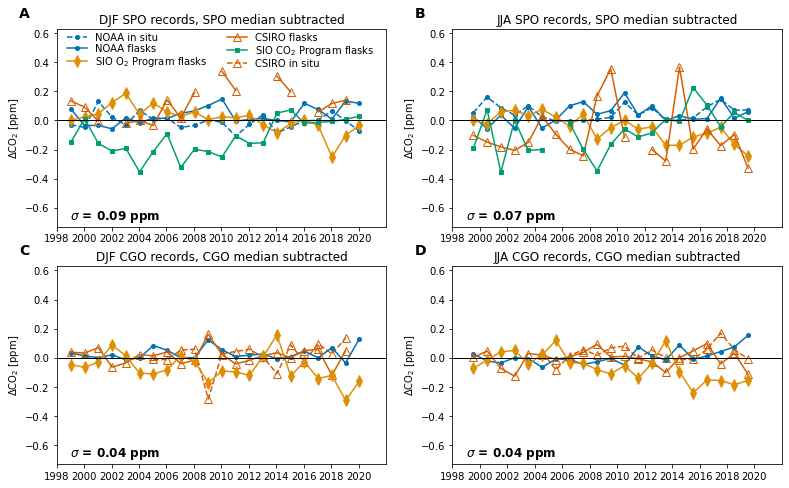

In [11]:
fig = plt.figure(figsize=(6, 8))

ncol = 2
nrow = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6.5*ncol, 4*nrow))   

marker_spec = figure_panels.marker_spec_co2_inst()

labels = dict(
    SPO_NOAA_insitu_CO2='NOAA in situ',
    SPO_NOAA_flask_CO2='NOAA flasks',
    SPO_SIO_O2_flask_CO2='SIO O$_2$ Program flasks',
    SPO_SIO_CDK_flask_CO2='SIO CO$_2$ Program flasks',
    SPO_CSIRO_flask_CO2='CSIRO flasks',
    CGO_NOAA_flask_CO2='NOAA flasks',
    CGO_SIO_O2_flask_CO2='SIO O$_2$ Program flasks',
    CGO_CSIRO_flask_CO2='CSIRO flasks',
    CGO_CSIRO_insitu_CO2='CSIRO in situ',
)

def ammendments(ax):
    ax.axhline(0, color='k', lw=1);
    ax.set_ylabel('$\Delta$CO$_2$ [ppm]')    
    ax.set_xticks(np.arange(1998, 2022, 2));
    ax.set_xlim([1998, 2022])
    ax.set_ylim([-0.73, 0.63]);

plotted_elements = []
legend_elements = []
    
    
dset = ds_djf.CO2.sel(record=record_list).copy()
# for stn in ['SPO', 'CGO']:
#     idx = np.where(dset.stncode == stn)[0]
#     dset[:, idx] = dset[:, idx]


x = dset.time + util.season_yearfrac['DJF']
for i, record in enumerate(dset.record.values):    
    ax = axs[0, 0] if 'SPO' in record else axs[1, 0]
    y = dset.sel(record=record)
    ls = '--' if 'insitu' in record else '-'
        
    inst = str(dset.sel(record=record).institution.values)
    p = ax.plot(x, y, linestyle=ls, label=labels[record], **marker_spec[inst])
    if labels[record] not in plotted_elements:
        legend_elements.append(p[0])
        plotted_elements.append(labels[record])


dset = ds_jja.CO2.sel(record=record_list).copy()
# for stn in ['SPO', 'CGO']:
#     idx = np.where(dset.stncode == stn)[0]
#     dset[:, idx] = dset[:, idx]


x = dset.time + util.season_yearfrac['JJA']
for i, record in enumerate(dset.record.values):
    ax = axs[0, 1] if 'SPO' in record else axs[1, 1]
    y = dset.sel(record=record)
    ls = '--' if 'insitu' in record else '-'
    inst = str(dset.sel(record=record).institution.values)    
    p = ax.plot(x, y, linestyle=ls, label=labels[record], **marker_spec[inst])
    if labels[record] not in plotted_elements:
        legend_elements.append(p[0])
        plotted_elements.append(labels[record])

for ax in axs.ravel():
    ammendments(ax)

    
xoff = 1
yoff = 0.05
str_text = f'$\sigma$ = {df_error.loc["djf"].SPO:0.2f} ppm'
axs[0, 0].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["djf"].CGO:0.2f} ppm'
axs[1, 0].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["jja"].SPO:0.2f} ppm'
axs[0, 1].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["jja"].CGO:0.2f} ppm'
axs[1, 1].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )    
          
axs[0, 0].set_title('DJF SPO records, SPO median subtracted')
axs[1, 0].set_title('DJF CGO records, CGO median subtracted')


axs[0, 1].set_title('JJA SPO records, SPO median subtracted')
axs[1, 1].set_title('JJA CGO records, CGO median subtracted')

util.label_plots(fig, [ax for ax in axs.ravel()])

axs[0, 0].legend(handles=legend_elements, ncol=2, loc=(0.02, 0.78), frameon=False, labelspacing=0.1)

util.savefig('SPO-CGO-record-discrepancies')